In [2]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from numpy import linalg as LA
import scipy.optimize as opt


def lotka_volterra(N, alpha):
    interaction_term = np.dot(alpha, N)  
    dNdt = N * (1 - N) - N * interaction_term
    return dNdt

def rk4_step(f, N, t, dt, h):
    if any(np.isnan(N)):
        return np.nan
    k1 = f(N, h)
    k2 = f(N + 0.5 * dt * k1, h)
    k3 = f(N + 0.5 * dt * k2, h)
    k4 = f(N + dt * k3, h)
    return N + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_lotka_volterra(alpha, N0, t_max, dt):
    t_values = np.arange(0, t_max, dt)
    N_values = np.zeros((len(t_values), len(N0)))
    N_values[0] = N0
    for i in range(1, len(t_values)):
        N_values[i] = rk4_step(lotka_volterra, N_values[i-1], t_values[i-1], dt, alpha)
    return t_values, N_values

def alphagen(mu,sigma, S):
    Alpha = np.random.normal(mu/S, sigma/np.sqrt(S), size=(S, S))
    np.fill_diagonal(Alpha, 0)
    return Alpha

def get_mean_var2(A):
    lst = np.ravel(A)
    other = []
    count = 0
    for i in lst:
        if i == 0:
            count = count + 1
        else:
            other.append(i)
    ot = np.array(other)
    mean = sum(ot)/(len(ot))
    var_sqrd = ot*ot
    moment2 = sum(var_sqrd)/(len(ot))
    var = moment2 - mean**2
    return mean , var

def get_mean_var(A):
    mean = np.mean(A)
    var = np.var(A)
    return [mean , var]


def cal_gamma(cAlpha,mu):
    clst = []
    count = 0
    cS = len(cAlpha[0])
    for i in range(cS):
        for j in range(i + 1, cS): 
            if cAlpha[i,j] == 0:
                count = count + 1
            else:
                centry = cAlpha[i,j]*cAlpha[j,i]
                clst.append(centry)
    ccorr = sum(clst)/(len(clst))
    ca = (ccorr - ((mu/cS)**2))
    return ca

def alphagen_withGamma(mu,sigma,gamma,S):
    Alpha = np.zeros((S,S))
    variance = (sigma**2)/S 
    mean = mu/S 
    cov_ab = (gamma * sigma**2) / S
    covariance_matrix = [[variance, cov_ab],
                         [cov_ab, variance]]
    means = [mean, mean]
    for i in range(S):
        for j in range(i + 1, S):
            ab_values = np.random.multivariate_normal(means, covariance_matrix,1)
            a = ab_values[:,0]
            b = ab_values[:,1]
            Alpha[i,j] = a[0]
            Alpha[j,i] = b[0]
    return Alpha

def Mixture_matrix(S,mu,sigma,c):
    G = nx.erdos_renyi_graph(S, c/S)
    adj_matrix = nx.to_numpy_array(G)
    alpha = np.random.normal(mu/c , sigma/(np.sqrt(c)),size=(S,S))
    interaction_matirx = adj_matrix * alpha
    np.fill_diagonal(interaction_matirx, 0)
    return interaction_matirx

def mixture_withGamma3(mu3,sigma3,gamma3,S3,c3):
    G3 = nx.erdos_renyi_graph(S3, c3/S3)
    adj_matrix3 = nx.to_numpy_array(G3)
    #Alpha Matrix
    Alpha3 = np.zeros((S3,S3))
    variance3 = (sigma3**2)/c3 
    mean3 = mu3/c3
    cov_ab3 = (gamma3 * sigma3**2)/c3
    covariance_matrix3 = [[variance3, cov_ab3],
                         [cov_ab3, variance3]]
    means3 = [mean3, mean3]
    for i in range(S3):
        for j in range(i + 1, S3):
            ab_values3 = np.random.multivariate_normal(means3, covariance_matrix3,1)
            a3 = ab_values3[:,0]
            b3 = ab_values3[:,1]
            Alpha3[i,j] = a3[0]
            Alpha3[j,i] = b3[0]
    #Interaction Matirx
    interaction_matirx3 = adj_matrix3 * Alpha3
    np.fill_diagonal(interaction_matirx3, 0)
    return interaction_matirx3

def mixture_withGamma(mu,sigma,gamma,S,c):
    G = nx.erdos_renyi_graph(S, c/S)
    adj_matrix = nx.to_numpy_array(G)
    Alpha = alphagen_withGamma(mu,sigma,gamma,S)
    interaction_matirx = adj_matrix * Alpha
    np.fill_diagonal(interaction_matirx, 0)
    return interaction_matirx

def findDelta_withGam(sig, gam):
    def findRootOf(x):
        # I went to log space in order to have better numerical convergence. Gam=-1 seems problematic.
        correctedGam = np.maximum(gam, -1+1e-8)
        return 2*np.log(sig) + 2*np.log( np.abs( 1 + correctedGam * w0(x)/w2(x) ) ) + np.log( w2(x) )
    return opt.newton(findRootOf,0)
    
def fullCav_withGam(mu,sig,gam):
    delt = findDelta_withGam(sig, gam)
    m = w1(delt)/(  delt*sig**2*( w2(delt)+gam*w0(delt) ) + mu*w1(delt)  )
    q = ( sig*( w2(delt)+gam*w0(delt) ) / ( delt*sig**2*(w2(delt)+gam*w0(delt)) + mu*w1(delt) ) )**2
    if gam==0:
        K = w0(delt)
    else:
        K = (1/sig**2 - w2(delt) )/gam - w0(delt)
    phi = w0(delt)
    return (phi, K, m, q, delt)

def w2(x):
    return (x**2+1)*norm.cdf(x)+x*norm.pdf(x)
def w1(x):
    return x*norm.cdf(x) + norm.pdf(x)
def w0(x):
    return norm.cdf(x)

## For (MU,SIGMA) with differnet gamma

In [4]:
S = 200
t_max = 500
dt = 0.05
gamma = -0.5
c = 6
N0_1 = np.random.uniform(0, 1, size=S)
N0_2 = np.random.uniform(0, 1, size=S)

#Get back list of d1,d2

# --- Parameter Space for (mu, sigma) ---
mu_values = np.linspace(-2, 5, 100) 
sigma_values = np.linspace(0, 4, 100) 
mu_grid, sigma_grid = np.meshgrid(mu_values, sigma_values)
d1_grid = np.zeros_like(mu_grid)
d2_grid = np.zeros_like(mu_grid)

In [ ]:
for i in range(mu_grid.shape[0]):
    for j in range(mu_grid.shape[1]):
        mu = mu_grid[i, j]
        sigma = sigma_grid[i, j]

        A = mixture_withGamma3(mu,sigma,gamma,S,c)

        Ts_1, Ns_1 = solve_lotka_volterra(A, N0_1, t_max, dt)
        if np.any(np.isnan(Ns_1[-1])):
            logd1 = 15
            logd2 = 15
        else:
            #D1 Calculations
            Vec1 = Ns_1[-1] - Ns_1[-2]
            diff = LA.norm(Vec1)
            d1 = diff / dt
            logd1 = np.log(d1)
            if logd1 < -15:
                logd1 = -15
            #D2 Calculations
            Ts_2, Ns_2 = solve_lotka_volterra(A, N0_2, t_max, dt)
            diff = np.linalg.norm(Ns_1[-1] - Ns_2[-1])
            logd2 = np.log(diff)
            if np.isnan(logd2) or logd2 > 15:
                logd2 = 15
            if logd2 < -15:
                logd2 = -15
        d2_grid[i, j] = logd2
        d1_grid[i, j] = logd1
    print("Done for",i ,"of 100")
    

print("READY!!!!")

/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_12030/3980231213.py:12: RuntimeWarning: overflow encountered in multiply
  dNdt = N * (1 - N) - N * interaction_term
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_12030/3980231213.py:12: RuntimeWarning: invalid value encountered in subtract
  dNdt = N * (1 - N) - N * interaction_term
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_12030/3980231213.py:22: RuntimeWarning: overflow encountered in multiply
  return N + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_12030/3977560448.py:17: RuntimeWarning: divide by zero encountered in log
  logd1 = np.log(d1)
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_12030/3977560448.py:23: RuntimeWarning: divide by zero encountered in log
  logd2 = np.log(diff)


Done for 0 of 100


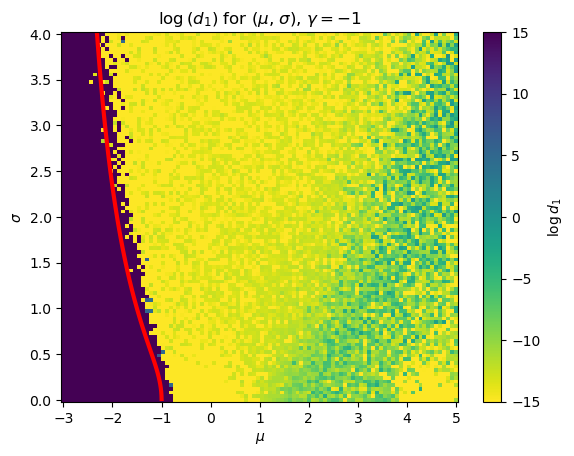

In [43]:

sigs = np.linspace(0.01,4,100)

deltas = []
for i in sigs:
    delt = findDelta_withGam(i, gamma)
    deltas.append(delt)

xs = []
ys = []
for j in deltas:
    x = -(j*w2(j))/(w1(j)*(w2(j) + gamma*w0(j)))
    y = (np.sqrt(w2(j)))/(w2(j) + gamma*w0(j))
    xs.append(x)
    ys.append(y)    



fig1, ax1 = plt.subplots()
P1 = ax1.pcolormesh(mu_grid, sigma_grid, d1_grid, cmap='viridis_r', shading='auto')  # Use shading='auto'
plt.plot(xs, ys, color='red', linewidth = 3)
#plt.axhline(y=np.sqrt(2)/(1+gamma), xmin=0.3, color='red', linewidth = 3)
ax1.set_title(r'$\log{(d_1)}$ for ($\mu$, $\sigma$), $\gamma = -1$')
ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$\sigma$')
fig1.colorbar(P1, ax=ax1, label=r'$\log{d_1}$')  # Add a label to the colorbar
plt.show()

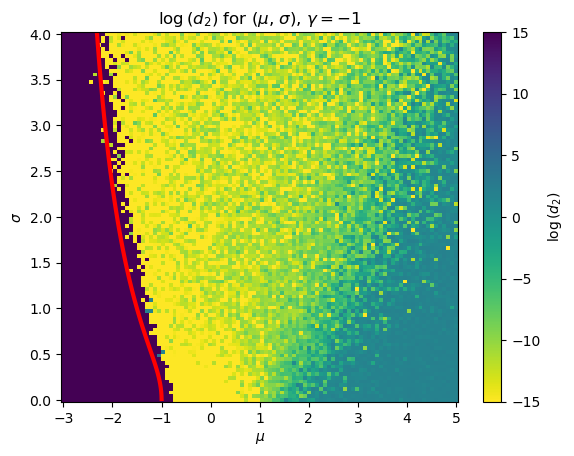

In [41]:
fig2, ax2 = plt.subplots()
P2 = ax2.pcolormesh(mu_grid, sigma_grid, d2_grid, cmap='viridis_r', shading='auto')  # Use shading='auto'
plt.plot(xs, ys, color='red', linewidth = 3)
#plt.axhline(y=np.sqrt(2)/(1+gamma), xmin=0.3, color='red', linewidth = 3)
ax2.set_title(r'$\log{(d_2)}$ for ($\mu$, $\sigma$), $\gamma = -1$')
ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$')
fig2.colorbar(P2, ax=ax2, label=r'$\log{(d_2)}$')  # Add a label to the colorbar
plt.show()

## For Gamma VS Sigma Plots

In [4]:
S = 200
t_max = 500
dt = 0.05
mu = 4
N0_1 = np.random.uniform(0, 1, size=S)
N0_2 = np.random.uniform(0, 1, size=S)

#Get back list of d1,d2

# --- Parameter Space for (mu, sigma) ---
gamma_values = np.linspace(-1, 1, 75) 
sigma_values = np.linspace(0, 5, 100) 
gamma_grid, sigma_grid = np.meshgrid(gamma_values, sigma_values)
d1_grid = np.zeros_like(gamma_grid)
d2_grid = np.zeros_like(gamma_grid)

In [ ]:
for i in range(gamma_grid.shape[0]):
    for j in range(gamma_grid.shape[1]):
        gamma = gamma_grid[i, j]
        sigma = sigma_grid[i, j]

        A = alphagen_withGamma(mu,sigma,gamma,S)

        Ts_1, Ns_1 = solve_lotka_volterra(A, N0_1, t_max, dt)
        if np.any(np.isnan(Ns_1[-1])):
            logd1 = 15
            logd2 = 15
        else:
            #D1 Calculations
            Vec1 = Ns_1[-1] - Ns_1[-2]
            diff = LA.norm(Vec1)
            d1 = diff / dt
            logd1 = np.log(d1)
            if logd1 < -15:
                logd1 = -15
            #D2 Calculations
            Ts_2, Ns_2 = solve_lotka_volterra(A, N0_2, t_max, dt)
            diff = np.linalg.norm(Ns_1[-1] - Ns_2[-1])
            logd2 = np.log(diff)
            if np.isnan(logd2) or logd2 > 15:
                logd2 = 15
            if logd2 < -15:
                logd2 = -15
        d2_grid[i, j] = logd2
        d1_grid[i, j] = logd1
    print("Done for",i+1 ,"of 100")
    

print("READY!!!!")

In [ ]:
fig3, ax3 = plt.subplots()
P3 = ax3.pcolormesh(gamma_grid, sigma_grid, d1_grid, cmap='RdBu', shading='auto')  # Use shading='auto'
ax3.set_title(r'$\log{(d_1)}$ for $(\gamma, \sigma)$')
ax3.set_xlabel(r'$\gamma$')
ax3.set_ylabel(r'$\sigma$')
fig3.colorbar(P3, ax=ax3, label=r'$\log{(d_2)}$')  # Add a label to the colorbar
plt.show()

In [ ]:
fig4, ax4 = plt.subplots()
P4 = ax4.pcolormesh(gamma_grid, sigma_grid, d2_grid, cmap='viridis_r', shading='auto')  # Use shading='auto'
ax4.set_title(r'$\log{(d_2)}$ for $(\gamma, \sigma)$')
ax4.set_xlabel(r'$\gamma$')
ax4.set_ylabel(r'$\sigma$')
fig4.colorbar(P3, ax=ax4, label=r'$\log{(d_2)}$')  # Add a label to the colorbar
plt.show()